## A 3-step model with Mass-action (reversible) kinetics


$$\mbox{S}_\rm{sugar} \overset{\varepsilon_t}{\rightleftharpoons} \mbox{S}_1 \overset{\varepsilon_m}{\rightleftharpoons} S_2 \overset{\varepsilon_r}{\rightleftharpoons} S_3$$

The rate laws are (Michaelis-Menten):
- Transporters:  $v_t = \varepsilon_t ~ \frac{k^\mathrm{cat}_t}{K_{\mathrm{M}, t}} (s_\rm{sugar} - \frac{s_1}{K^\mathrm{eq}_t})$
- Metabolism:    $v_m = \varepsilon_m ~ \frac{k^\mathrm{cat}_m}{K_{\mathrm{M}, m}} (s_1 - \frac{s_2}{K^\mathrm{eq}_m})$
- Ribosomes:     $v_r = \varepsilon_r ~ \frac{k^\mathrm{cat}_r}{K_{\mathrm{M}, R}} (s_2 - \frac{s_3}{K^\mathrm{eq}_r})$



We assume that $s_0$ is fixed and that the system is at steady-state ($v_t = v_m = v_r = \mu$). The enzymes and metabolites are bound by two constraints:
- $\varepsilon_t + \varepsilon_m + \varepsilon_r \leq \varepsilon^\mathrm{tot}$
- $K^\mathrm{eq}_t \cdot K^\mathrm{eq}_m \cdot K^\mathrm{eq}_r = K^\mathrm{eq}_\mathrm{tot}$

Then, the maximal flux (assuming the total enzyme $\varepsilon^\mathrm{tot}$ is distributed optimally) is:
$$\mu = \varepsilon^\mathrm{tot} \frac{s_\rm{sugar} K^\mathrm{eq} - s_3}{(\sqrt{\gamma_t} + \sqrt{\gamma_m} + \sqrt{\gamma_r})^2}$$
where:
- $\gamma_t \equiv \frac{K_{\mathrm{M}, t}}{k^\mathrm{cat}_t} \cdot K^\mathrm{eq}_t \cdot K^\mathrm{eq}_m \cdot K^\mathrm{eq}_r$
- $\gamma_m \equiv \frac{K_{\mathrm{M}, m}}{k^\mathrm{cat}_m} \cdot K^\mathrm{eq}_m \cdot K^\mathrm{eq}_r$
- $\gamma_m \equiv \frac{K_{\mathrm{M}, r}}{k^\mathrm{cat}_r} \cdot K^\mathrm{eq}_r$


The solution for the individual enzyme demands (are):
$$\varepsilon_t^* = \varepsilon^\mathrm{tot} \frac{\sqrt{\gamma_t}}{\sqrt{\gamma_t} + \sqrt{\gamma_m} + \sqrt{\gamma_r}}$$
$$\varepsilon_m^* = \varepsilon^\mathrm{tot} \frac{\sqrt{\gamma_m}}{\sqrt{\gamma_t} + \sqrt{\gamma_m} + \sqrt{\gamma_r}}$$
$$\varepsilon_r^* = \varepsilon^\mathrm{tot} \frac{\sqrt{\gamma_r}}{\sqrt{\gamma_t} + \sqrt{\gamma_m} + \sqrt{\gamma_r}}$$

<img src="../figures/growing_cell_model.svg" width="800">

In [1]:
import numpy as np
import sympy
import seaborn as sns
from scipy.optimize import minimize, LinearConstraint, Bounds
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["text.usetex"] = True
sympy.init_printing(use_latex=True, scale=2.0, forecolor="black", latex_mode="equation")

In [2]:
# define variables and parameters:
E_tot = sympy.Symbol(r"\varepsilon_{tot}")
s_sugar = sympy.symbols(r"s_{sugar}")
s_3 = sympy.symbols(r"s_3")
kcat = sympy.symbols(r"k^{cat}_t k^{cat}_m k^{cat}_r")
Km = sympy.symbols(r"K_{M;t} K_{M;m} K_{M;r}")
Keq = sympy.symbols(r"K_{eq;t} K_{eq;m} K_{eq;r}")

gamma = [
    Km[0]/kcat[0] * Keq[0] * Keq[1] * Keq[2],
    Km[1]/kcat[1] * Keq[1] * Keq[2],
    Km[2]/kcat[2] * Keq[2],
]
sum_of_sqrt_gamma = sum([g**(1/2) for g in gamma])
J_opt = E_tot * (s_sugar * Keq[0] * Keq[1] * Keq[2] - s_3) / sum_of_sqrt_gamma**2

enzyme_demands = [
    E_tot * g**(1/2) / sum_of_sqrt_gamma
    for g in gamma
]

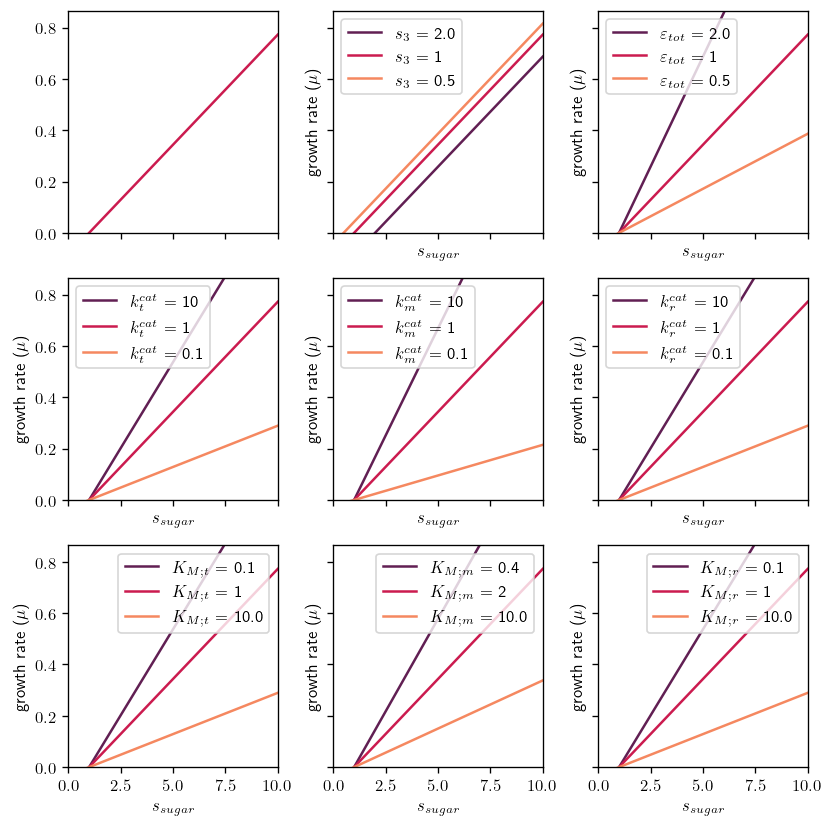

In [3]:
s_sugar_range = np.linspace(0, 10, 5)
colors = sns.color_palette("rocket", 3)
default_params = {
    Km[0]: 1,
    Km[1]: 2,
    Km[2]: 1,
    kcat[0]: 1,
    kcat[1]: 1,  
    kcat[2]: 1,
    Keq[0]: 1,
    Keq[1]: 1,
    Keq[2]: 1,
    s_3: 1,
    E_tot: 1,
}
def plot_monod_curve(ax, color=colors[1], key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        label = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        label = "default parameters"

    _f = sympy.lambdify(s_sugar, J_opt.subs(p))
    ax.plot(s_sugar_range, _f(s_sugar_range), label=label, color=color)

def plot_three_monod_curves(ax, key, fold_change: float=10.0):
    plot_monod_curve(ax, color=colors[0], key=key, value=default_params[key]*fold_change)
    plot_monod_curve(ax, color=colors[1], key=key, value=default_params[key])
    plot_monod_curve(ax, color=colors[2], key=key, value=default_params[key]/fold_change)
    ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
    ax.set_ylabel(f"growth rate ($\mu$)")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, None)
    ax.legend()

    
fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=120, sharex=True, sharey=True)

plot_monod_curve(axs[0, 0])
plot_three_monod_curves(axs[0, 1], key=s_3, fold_change=2.0)
plot_three_monod_curves(axs[0, 2], key=E_tot, fold_change=2.0)
plot_three_monod_curves(axs[1, 0], key=kcat[0], fold_change=10)
plot_three_monod_curves(axs[1, 1], key=kcat[1], fold_change=10)
plot_three_monod_curves(axs[1, 2], key=kcat[2], fold_change=10)
plot_three_monod_curves(axs[2, 0], key=Km[0], fold_change=0.1)
plot_three_monod_curves(axs[2, 1], key=Km[1], fold_change=0.2)
plot_three_monod_curves(axs[2, 2], key=Km[2], fold_change=0.1)

fig.tight_layout()
fig.savefig("../figures/mass_action_mu_vs_s0.pdf")

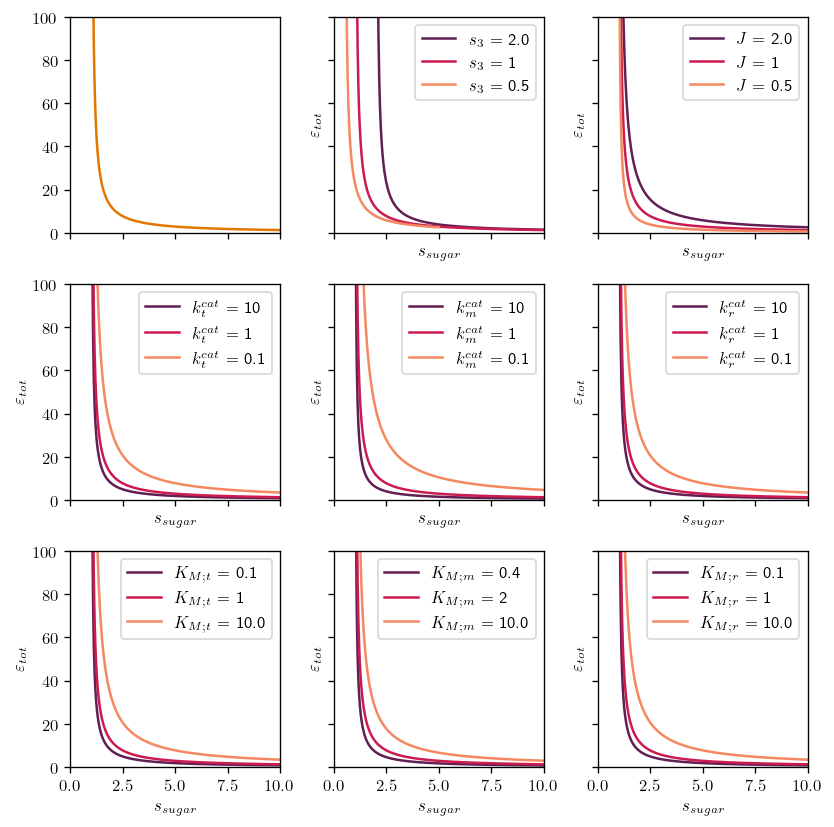

In [4]:
# now plot the enzyme demand per flux:
J_steady_state = sympy.Symbol("J")
colors = sns.color_palette("rocket", 3)
default_params = {
    Km[0]: 1,
    Km[1]: 2,
    Km[2]: 1,
    kcat[0]: 1,
    kcat[1]: 1,  
    kcat[2]: 1,
    Keq[0]: 1,
    Keq[1]: 1,
    Keq[2]: 1,
    s_3: 1,
    E_tot: 1,
    J_steady_state: 1,
}
enzyme_demand = J_steady_state / J_opt


def plot_enzye_demand(ax, color="#e17701", key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        label = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        label = "default parameters"
    s_sugar_range = np.linspace(p[s_3]*1.01, p[s_3]*10, 500)
    _f = sympy.lambdify(s_sugar, enzyme_demand.subs(p))
    ax.plot(s_sugar_range, _f(s_sugar_range), label=label, color=color)

def plot_three_demand_curves(ax, key, fold_change: float=10.0):
    plot_enzye_demand(ax, color=colors[0], key=key, value=default_params[key]*fold_change)
    plot_enzye_demand(ax, color=colors[1], key=key, value=default_params[key])
    plot_enzye_demand(ax, color=colors[2], key=key, value=default_params[key]/fold_change)
    ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
    ax.set_ylabel(r"$\varepsilon_{tot}$")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 100)
    ax.legend()

    
fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=120, sharex=True, sharey=True)

plot_enzye_demand(axs[0, 0])
plot_three_demand_curves(axs[0, 1], key=s_3, fold_change=2.0)
plot_three_demand_curves(axs[0, 2], key=J_steady_state, fold_change=2.0)
plot_three_demand_curves(axs[1, 0], key=kcat[0], fold_change=10)
plot_three_demand_curves(axs[1, 1], key=kcat[1], fold_change=10)
plot_three_demand_curves(axs[1, 2], key=kcat[2], fold_change=10)
plot_three_demand_curves(axs[2, 0], key=Km[0], fold_change=0.1)
plot_three_demand_curves(axs[2, 1], key=Km[1], fold_change=0.2)
plot_three_demand_curves(axs[2, 2], key=Km[2], fold_change=0.1)

fig.tight_layout()
fig.savefig("../figures/mass_action_Etot_vs_s0.pdf")

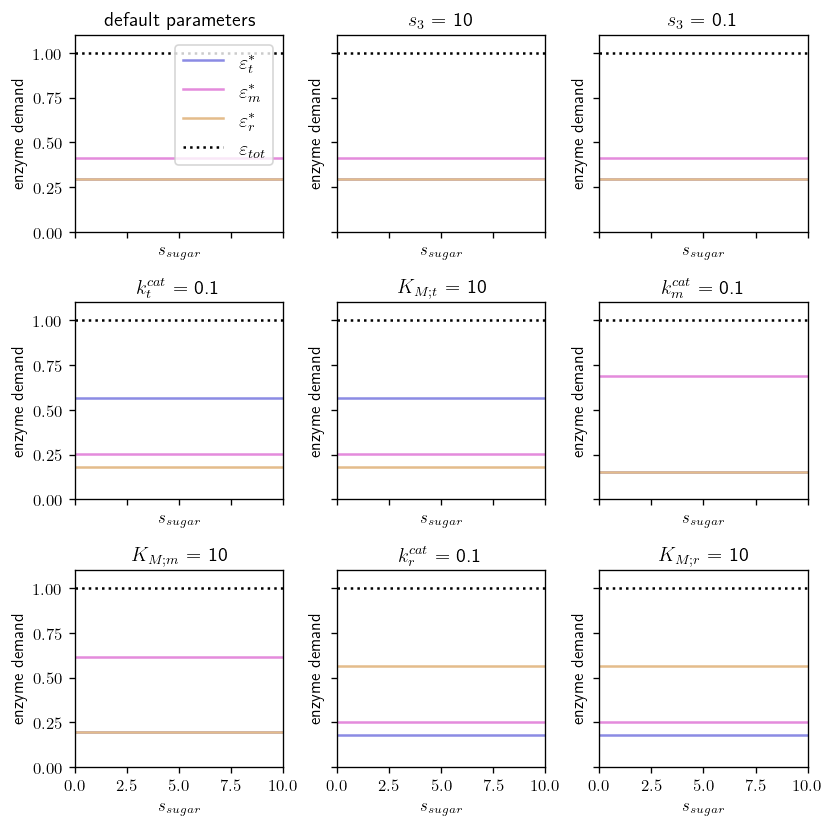

In [5]:
# plot the 3 enzyme demands as a function of s_sugar

s_sugar_range = np.linspace(0, 10, 100)
colors = ["#8b8be4", "#e48bdc", "#e4bc8b"]
default_params = {
    Km[0]: 1,
    Km[1]: 2,
    Km[2]: 1,
    kcat[0]: 1,
    kcat[1]: 1,
    kcat[2]: 1,
    Keq[0]: 1,
    Keq[1]: 1,
    Keq[2]: 1,
    s_3: 1,
    E_tot: 1,
}

def plot_demands(ax, key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        title = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        title = "default parameters"

    for demand, letter, c in zip(enzyme_demands, ["t", "m", "r"], colors):
        d = demand.subs(p)
        ax.plot([0, 10], [d, d], label=f"$\\varepsilon^*_{letter}$", color=c)
            
    ax.set_title(title)

fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=120, sharex=True, sharey=True)

plot_demands(axs[0, 0])
plot_demands(axs[0, 1], s_3, 10)
plot_demands(axs[0, 2], s_3, 0.1)
plot_demands(axs[1, 0], kcat[0], 0.1)
plot_demands(axs[1, 1], Km[0], 10)
plot_demands(axs[1, 2], kcat[1], 0.1)
plot_demands(axs[2, 0], Km[1], 10)
plot_demands(axs[2, 1], kcat[2], 0.1)
plot_demands(axs[2, 2], Km[2], 10)

for ax in axs.flat:
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
    ax.set_ylabel("enzyme demand")
    ax.plot([0, 10], [1, 1], "k:", label=r"$\varepsilon_{tot}$")
axs[0, 0].legend(loc="upper right", fontsize=12)
    
fig.tight_layout()
fig.savefig("../figures/mass_action_demands_vs_s0.pdf")

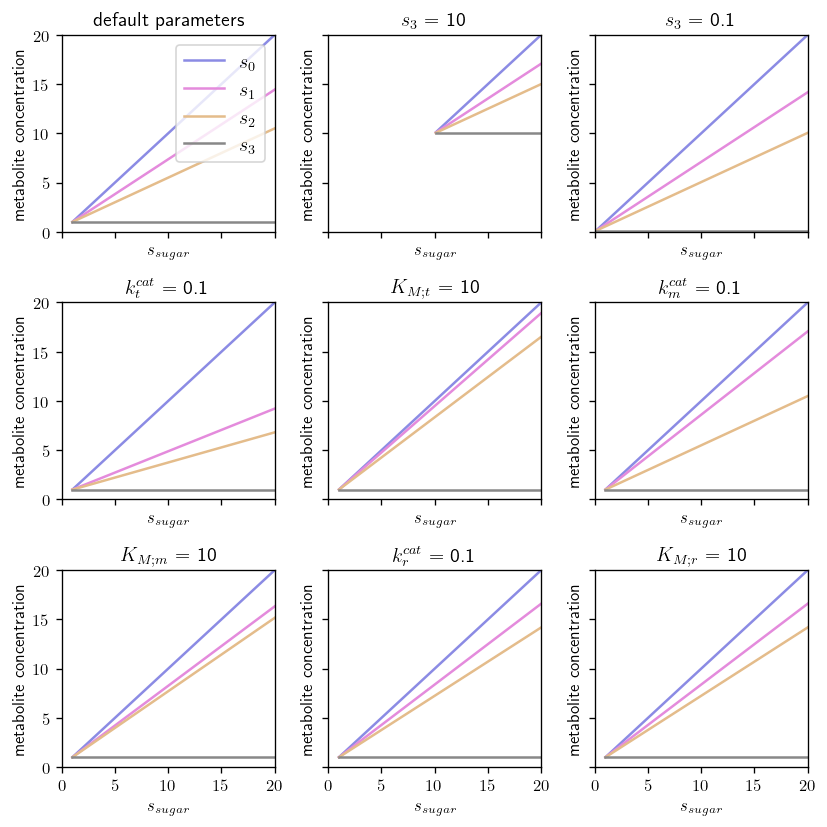

In [6]:
# plot the 3 enzyme demands as a function of s_sugar

# J* = e_i * kcat_i * s_i-1 / (s_i-1 + K_i)   =>   s_i-1 = K_i / (e_i * kcat_i / J* - 1)

s_1 = Keq[0] * (s_sugar - J_opt / (kcat[0] * enzyme_demands[0]))
s_2 = Keq[0] * (s_1 - J_opt / (kcat[1] * enzyme_demands[1]))
metabolite_conc = [
    s_sugar,
    sympy.simplify(s_1),
    sympy.simplify(s_2),
    s_3
]

colors = ["#8b8be4", "#e48bdc", "#e4bc8b", "#888888"]
default_params = {
    Km[0]: 1,
    Km[1]: 2,
    Km[2]: 1,
    kcat[0]: 1,
    kcat[1]: 1,
    kcat[2]: 1,
    Keq[0]: 1,
    Keq[1]: 1,
    Keq[2]: 1,
    s_3: 1,
    E_tot: 1,
}

def plot_metabolites(ax, key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        title = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        title = "default parameters"

    for i, conc in enumerate(metabolite_conc):
        s_sugar_range = np.linspace(p[s_3]*1.01, 20, 5)
        _f = sympy.lambdify(s_sugar, conc.subs(p))
        ax.plot(s_sugar_range, [_f(s) for s in s_sugar_range], label=f"$s_{i}$", color=colors[i])
            
    ax.set_title(title)

fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=120, sharex=True, sharey=True)

plot_metabolites(axs[0, 0])
plot_metabolites(axs[0, 1], s_3, 10)
plot_metabolites(axs[0, 2], s_3, 0.1)
plot_metabolites(axs[1, 0], kcat[0], 0.1)
plot_metabolites(axs[1, 1], Km[0], 10)
plot_metabolites(axs[1, 2], kcat[1], 0.1)
plot_metabolites(axs[2, 0], Km[1], 10)
plot_metabolites(axs[2, 1], kcat[2], 0.1)
plot_metabolites(axs[2, 2], Km[2], 10)

for ax in axs.flat:
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
    ax.set_ylabel("metabolite concentration")
axs[0, 0].legend(loc="upper right", fontsize=12)
    
fig.tight_layout()
fig.savefig("../figures/mass_action_metabolites_vs_s0.pdf")